# Bibliotecas e Funções

In [122]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import os
import sys

# Verificação de tipos
from typing import List, Tuple, Set

# Programação funcional e utilitários
import funcy as fp
import itertools
from functools import partial

# Recursos para texto
import re

# Manipulação e análise dos dados
import numpy as np
import pandas as pd

# Redução de Dimensionalidade e Análise de Similaridade
from sklearn.mixture import GaussianMixture

# Rastreamento de experimentos e modelos
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2
sys.path.append(os.path.abspath(os.path.pardir))
from src import settings
from src.utils.text import clean_text, load_stopwords, SPLIT_PATTERN
from src.utils.notebooks import display_side_by_side, plot_word_cloud
from src.utils.experiments import set_dataset_split, extract_tokens, compute_entropy
from src.pipeline.training_pipeline import compute_embeddings_frame


# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calibração de Modelo Não Supervisionado de Intenções de Busca

O objetivo deste notebook é estruturar os recursos para ajustar a criação do modelo não supervisionado de intenções de busca considerando as intenções:
 - **Foco**: alguém com uma necessidade mais específica e que deseja encontrar a melhor opção dentre as alternativas. Por exemplo, alguém em busca de um móvel para a sala, uma *action figure* para a estante ou doces para uma festa.
 - **Exploração**: uma pessoa que pode ter um objetivo ou necessidade, mas não tem a noção de qual produto exatamente será o melor. A exemplo disso, pode-se ter alguém querendo presentear uma pessoa, mas sem a noção exata do que sera o presente ou uma pessoa que quer passar por produtos como quem visita um shopping ou feira de artesanatos, para eventualmente encontrar algo que seja de interesse.

 
O estudo para a organização da metodologia de criação do modelo foi realizado em [04_Classificacao_Nao_Supervisionada.ipynb](04_Classificacao_Nao_Supervisionada.ipynb). A partir dele, foi possível determinar as funções necessárias e os hiperparâmetros que podem controlar a qualidade da distinção das intenções, como o algoritmo de agrupamento, o número de grupos e o limiar de entropia. Considerando a necessidade de explorar o espaço de valores, registrar os resultados e permitir o reuso dos parâmetros e funções utilizados, o notebook apresenta o código refatorado e com o rastreamento das experimentações com o Mlflow.

## Configurações de Rastreamento de Experimentos

In [2]:
EXPERIMENT_NAME = '02_UnsupervisedClassification'
EXPERIMENT_RUN_NAME = f'Structuring'

mlflow_client = MlflowClient()

# Se o experimento já não existir no MlFlow, criar um e recuperar ID
experiment = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    mlflow_client.create_experiment(EXPERIMENT_NAME)
    experiment = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME)

EXPERIMENT_ID = experiment.experiment_id
del experiment

## Carregamento de Dados

Para trabalhar o problema de classificação de produtos em categorias, é preciso utilizar o conjunto de dados de treinamento, dividido em  [01_Estruturacao.ipynb](01_Estruturacao.ipynb). Ainda que a análise seja não supervisonada, os dados de teste continuam isolados para evitar qualquer vazamento de informação e permitir a estimativa mais real do comportamento conjunto dos modelos com dados não vistos anteriormente.

In [3]:
columns_to_read = ['product_id', 'query', 'search_page', 'position', 'title', 'concatenated_tags', 'category', 'creation_date']

frame = pd.read_csv(os.path.join(settings.DATA_PATH, 'interim', 'training.csv'), usecols=columns_to_read)

## Hiperparâmetros e Funções

Os hiperparâmetros e funções utilizadas são definidos a seguir.

In [10]:
def count_frame_items(base_frame: pd.DataFrame, group_column: str, count_column: str) -> pd.Series:
    return (base_frame
            [[group_column, count_column]]
            .drop_duplicates()
            .assign(records=1)
            .groupby(group_column)
            .sum()
            ['records']
           )


def compute_frame_column_entropy(base_frame: pd.DataFrame, group_column: str, count_column: str) -> pd.Series:
    return (base_frame
            [[group_column, count_column]]
            .groupby(group_column)
            .apply(lambda f: compute_entropy(f[count_column].to_numpy()))
           )


def get_qualified_queries(base_frame: pd.DataFrame, minimum_number_of_products: int) -> Set[str]:
    return set(base_frame
               [['query']]
               .assign(products=1)
               .groupby('query')
               .sum()
               .reset_index()
               .loc[lambda f: f['products'] >= minimum_number_of_products]
               ['query']
               .unique()
               .tolist()
              )


EMBEDDING_COLUMNS = ['title']
MINIMUM_NUMBER_OF_PRODUCTS = 2
ENTROPY_THRESHOLD = 0.65

embeddings_frame = pd.concat([frame, compute_embeddings_frame(frame, EMBEDDING_COLUMNS)], axis=1)

Agrupamento dos produtos pelo título.

In [29]:
embeddings_columns_names = [f'{item}_embedding' for item in EMBEDDING_COLUMNS]
products_embeddings_frame = (embeddings_frame
                             .drop_duplicates('title')
                             [['title'] + embeddings_columns_names]
                            )

X = np.stack(products_embeddings_frame[embeddings_columns_names].to_numpy().squeeze(), axis=0)

gmm = GaussianMixture(n_components=50, covariance_type="diag").fit(X)
products_embeddings_frame['cluster'] = gmm.predict(X)

del X

Atribuição dos grupos aos produtos

In [12]:
embeddings_frame = pd.merge(embeddings_frame, products_embeddings_frame[['title', 'cluster']], on='title', how='left')
embeddings_frame.head()

,product_id,query,search_page,position,title,concatenated_tags,creation_date,category,title_embedding,cluster
0,11394449,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,Decoração,"[-0.008050227, -0.008805177, 0.05007785, 0.052670166, -0.008375991, -0.08733791, 0.08137107, -0.047023904, -0.084045015, -0.114914, -0.015285425, ...",49
1,15534262,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos long drink canecas,2018-04-04 20:55:07,Papel e Cia,"[-0.045109227, -0.025397679, 0.03495742, 0.0006268186, -0.058263194, -0.07574056, -0.011842876, -0.024876617, 0.008490498, -0.011903388, 0.0148019...",47
2,15877252,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,Bebê,"[-0.009625531, -0.0075558904, 0.04198961, -0.021121407, 0.009023795, -0.057901293, 0.0071319044, 0.0013754551, -0.006352756, -0.032950606, 0.01115...",7
3,15917108,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,Decoração,"[-0.018868096, -0.06439885, 0.059289288, 0.054038137, -0.010600663, -0.051247593, -0.054422166, 0.0020310725, 0.00487231, -0.05863656, -0.02942790...",7
4,4336889,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,Lembrancinhas,"[-0.027158957, -0.027052542, 0.01778969, -0.028899949, -0.017072415, -0.01605464, -0.0044643283, -0.0142439585, -0.011826115, -0.036974575, 0.0142...",17


Cálculo de entropia e de métricas de consultas para análise da separação das intenções.

In [123]:
qualified_queries = get_qualified_queries(frame, MINIMUM_NUMBER_OF_PRODUCTS)

# Separar embeddings e atributos de interesse das buscas selecionadas
embeddings_entropy_frame = (embeddings_frame
                            .loc[lambda f: f['query'].isin(qualified_queries)]
                            [['query', 'cluster']]
                            .drop_duplicates('query')
                            .set_index('query')
                           )


frame_slice = embeddings_frame.loc[lambda f: f['query'].isin(qualified_queries)]

embeddings_entropy_frame = (embeddings_entropy_frame
                            .merge(count_frame_items(frame_slice, 'query', 'title').rename('products'),
                                   left_index=True, right_index=True)
                            .merge(count_frame_items(frame_slice, 'query', 'cluster').rename('clusters'),
                                   left_index=True, right_index=True)
                            .merge(compute_frame_column_entropy(frame_slice, 'query', 'cluster').rename('entropy'),
                                   left_index=True, right_index=True)
                           )

del frame_slice

Distribuição de entropia das buscas.

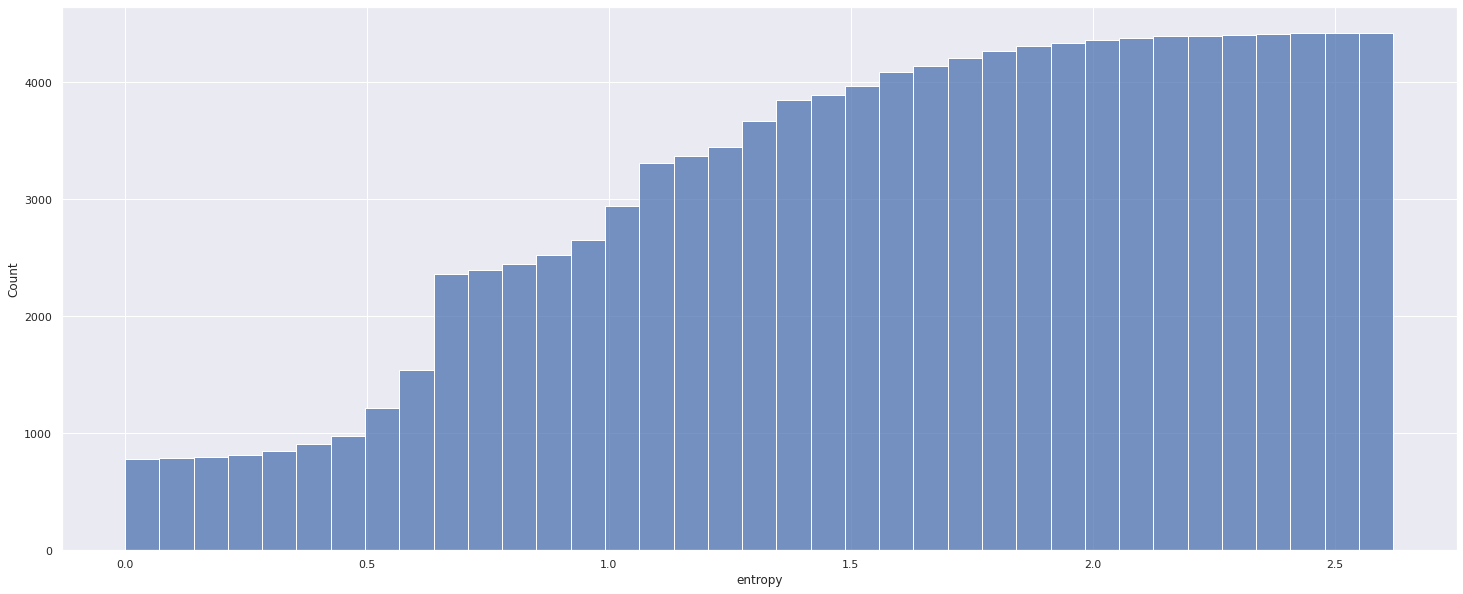

In [19]:
sns.histplot(embeddings_entropy_frame.loc[lambda f: f['products'] >= MINIMUM_NUMBER_OF_PRODUCTS]['entropy'], cumulative=True)
plt.show()

Comportamento das consultas pelos grupos de intenções.

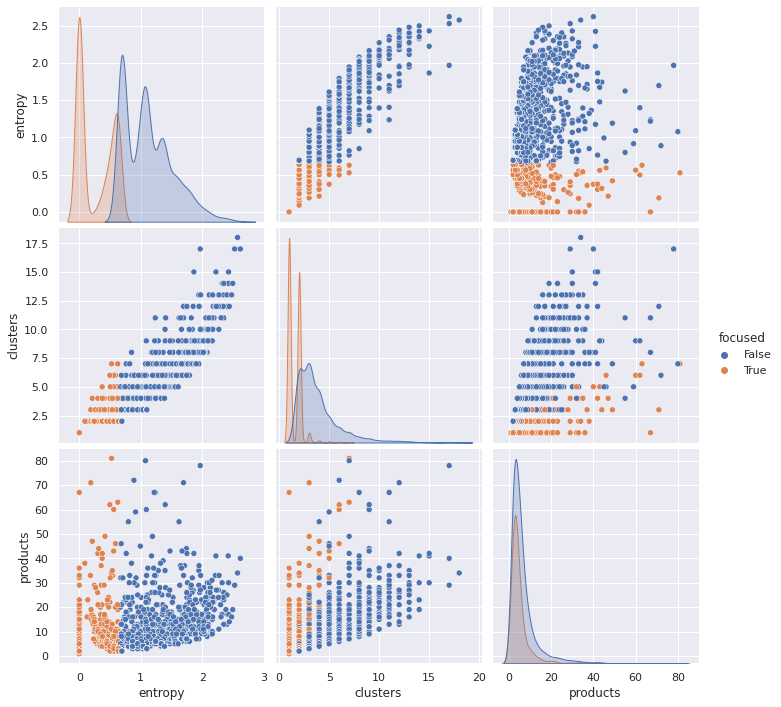

In [20]:
entropy_threshold = 0.65 #.65
sns.pairplot(embeddings_entropy_frame
             .assign(focused=lambda f: f['entropy'] <= entropy_threshold)
             [['entropy', 'clusters', 'products', 'focused']], height=3.33, hue='focused')
plt.show()
plt.savefig()